# High Order Linear Multistep Preconditioners

## Constructing linear multistep methods (LMMs)
LMMs are based on Taylor expanding the solution in time and then summing solutions and right hand side evaluations at different steps to cancel as many terms in the Taylor expansion.
The Taylor expansion of the solution at time $t$, which we want to solve for is
$$u(t-h) = \sum^{p}_{i=0}\frac{(-h)^i}{i!}\partial_t^i u(t) = \mathcal{O}(h^{p+1}).$$
Since we want to compute $u(t)$, we want to cancel all other terms in the Taylor expansion.

The solutions at previous steps share the same expansion, but the right hand side evaluations are missing the solution and a power of the step size.
Their expansion is
$$f(t-h) = \sum^p_{i=1}\frac{(-h)^{(i-1)}}{(i-1)!}\partial_t^{i}u(t) + \mathcal{O}(h^{p+1}).$$

The linear multistep method will then look like
$$u(t) = \sum_{i=0}^p \left(\alpha_i u(t-h_i) + \beta_i f\left(u\left(t-h_i\right), t-h_i\right)\right),$$
and we need to choose $\alpha_i$ and $\beta_i$ in a way that suits us and that cancels the most possible terms in the Taylor expansion.

What suits us best is mainly determined by what we have available, which is, in the pySDC implementation, the initial conditions and the right hand side evaluations at all the nodes.
That means with $h_i$ the time differences to where we want to solve for in descending order: $\alpha_0=1$ and $\beta_i \neq 0$.
In particular, $\beta_p\neq 0$, to make the scheme implicit.

In order to cancel as many terms as we can, we setup a linear system of equations that carries the coefficients of the Taylor expansion.
We construct a matrix $A$ with
$$A_{ij} = \cases{(-h_i)^j / j!, & j = 0\\
                  (-h_i)^{(j-1)} / (j-1)!, & i,j > 0}.$$
We will then proceed to solve a system $Ax=b$, which means we need a vector $b$ on the right hand side.
Since we want to solve for the solution at time $t$ itself and want to cancel all other terms, we need a one in the first entry, corresponding to $u(t)$ and zeros everywhere else:
$$b = \delta_{i0}.$$

Conveniently for us, $u(t-h_0)$ is the only term carrying $u(t)$ in its expansion, and since we want a one in the corresponding row of the solution, we will always get $\alpha_0=1$, which means we don't have to modify the implementaion of pySDC in the sweeps.
The remaining coefficients make up a single row of the preconditioner and are the $\beta_i$ coefficients that will be multiplied to the right hand side evaluations in the sweeps.

Crucially, we increase the order of the LMM by one in each row of the preconditioner.
In the first row, we get the trapezoidal rule (or implicit Euler, if we set $\beta_0=0$), and then we gain an order in the expansions with each row.

Let's look at this in practice:
## Numerical experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pySDC.projects.Resilience.accuracy_check import plot_all_errors, plot_orders
from pySDC.projects.Resilience.vdp import run_vdp
from pySDC.projects.Resilience.advection import run_advection
from pySDC.projects.Resilience.piline import run_piline
from pySDC.playgrounds.Preconditioners.heat import run_heat

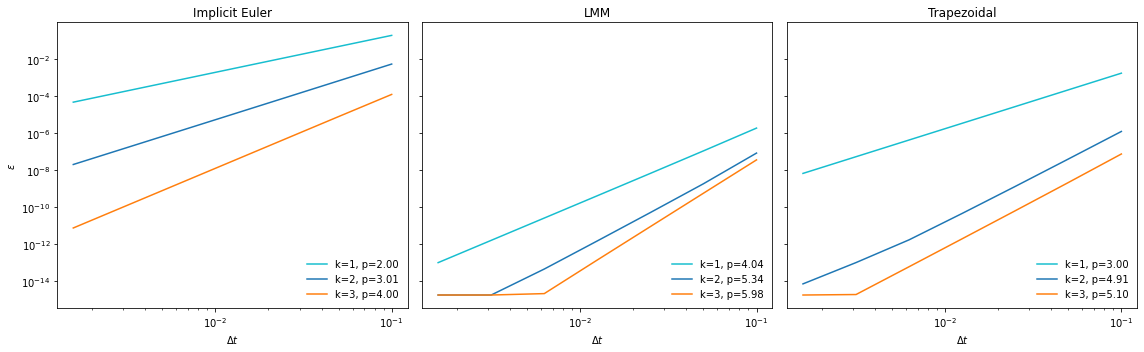

In [2]:
num_nodes = 3
IE_desc = {'sweeper_params': {'QI': 'IE', 'num_nodes': num_nodes}}
Taylor_desc = {'sweeper_params': {'QI': 'LMM', 'num_nodes': num_nodes}}
trap_desc = {'sweeper_params': {'QI': 'TRAP', 'num_nodes': num_nodes}}
ks = [1, 2, 3]

def compare_preconditioners(prob, dt_list, ks, Tend_fixed):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
    descriptions = [IE_desc, Taylor_desc, trap_desc]
    titles = ['Implicit Euler', 'LMM', 'Trapezoidal']
    for i in range(len(descriptions)):
        plot_orders(axs[i], ks, True, Tend_fixed=Tend_fixed, custom_description=descriptions[i], dt_list=dt_list, prob=prob)
        axs[i].set_title(titles[i])
        if i > 0:
            axs[i].set_ylabel('')

    fig.tight_layout()


Tend = 0.1
compare_preconditioners(run_piline, Tend * 2.**(-np.arange(7)), ks, Tend)

What you see above is the order for the pi-line problem, a non-linear ordinary differential equation, which we integrate with an IMEX scheme such that we only need to solve linear systems in each step.
$k$ is the number of sweeps and $p$ is the order of the scheme.

Each of the panels shows a different time marching scheme for the preconditioner and we see the expected $p=k+1$ for implicit Euler.
For the trapezoidal rule, we increase the order of accuracy by two with each sweep, which is what we expected, but at the third sweep we stay at order 5 instead of the maximal possible order 6, for some reason.
The LMM, on the other hand, gives us a thrid order accurate method in the first sweep, but then the order rises only by one with each sweep.
This behaviour is slightly odd, but maybe this is just down to numerics.

This looks nice! We did no extra work and yet we got a higher order method!

Now let's try a partial differential equation:

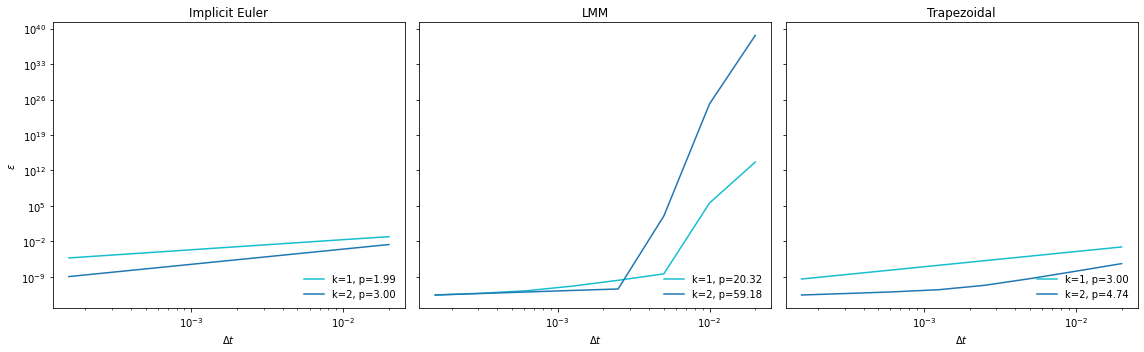

In [4]:
Tend = 2e-2
ks = [1, 2]
compare_preconditioners(run_advection, Tend * 2.**(-np.arange(8)), ks, None)

Cowabanga! Looks like we need to talk stability...

## Stability of the preconditioners
The standart tool for analysing LMMs are the characteristic polynomials.
Since the only coefficient for $u$ is one for the initial conditions (but on the right hand side), we get a first characteristic polynomial
$$\rho(r) = r^p - 1.$$

Now, first of all, we need to make sure that our method is convergent, by showing that it is consistent and zero stable.
Showing that a scheme is consistent usually works by computing the linear difference operator and Taylor expanding all the terms to make sure everything cancels up to the order of consistency.
Since that is exactly how we derived the scheme, it is consistent to the order of the number of collocation nodes by default.

To show zero stability, we need to make sure that the roots of the first characteristic polynomial are all smaller or equal to one and that they are distinct.
In that case, the solution will stay bounded when applied to the test problem $\partial_t u = 0$.
Since our first characteristic polynomial is particularly simple, we can immediately see that the roots $r = 1^{1/p}$ are all bounded by one and destinct.

So we have a consistent and zero stable method, which is hence convergent by Dahlquists theorem.
But is it A-stable?
Dahlquist, who was very helpful with his theorems up to now, will crush our dreams at this point with his second barrier theorem, which states that there is no A-stable LMM with order greater than 2.
Wanting to improve on the trapezoidal rule, it is at this point that we realize that we can't.

Now, we can of course find problems that fit within the stability region of the LMMs in the preconditioners, but they depend on the nodes that we use, which impact the second characteristic polynomial and hence the stability polynomial.
So nothing stops us from checking if this might be a good preconditioner for our problem, but it is difficult to make general statements about where this may be applicable.